## Create visualizations for local metrics (neighborhoods of data)

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir, load_image, get_image_id
from utils.model_utils import prepare_device, quick_predict
from utils.knn_utils import display_image_paths
from utils.visualizations import plot, histogram, show_image_rows, make_grid
from utils.df_utils import load_and_preprocess_csv, get_sorted_idxs
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

In [3]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')

config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'

class_name = 'airplane'
n_select = 100

In [4]:
# Load config file, models, and dataloader
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

config_json = read_json(config_path)
K = config_json['editor']['K']


device, device_ids = prepare_device(config['n_gpu'])

trial_paths_path_template = os.path.join('saved', 'edit', 'trials', 'CINIC10_ImageNet-VGG_16', '{}_{}', '{}', 'trial_paths.txt')

timestamp = '0127_103716'
n_display = 9
show = False

trial_paths_path = trial_paths_path_template.format(class_name, n_select, timestamp)

### Create visualizations for top 10 nearest neighbors

In [52]:
# Function to take in KNN object and display neighbors for all combos of key/val and logits/features/images
def show_nearest_neighbors(key_path,
                           value_path,
                           knn,
                           n_display,
                           image_id,
                           save_dir,
                           title_template,
                           show=True):
                           # title=None):
    data_modes = knn.keys()
    image_title_template = 'GT: {}\nPred: {}\nDist: {:.3f}'

    target_class = os.path.basename(os.path.dirname(key_path))
    predicted_key_class_idx = np.argmax(knn['logits']['anchor_data'][0])
    predicted_key_class = class_list[predicted_key_class_idx]
    
    predicted_value_class_idx = np.argmax(knn['logits']['anchor_data'][1])
    predicted_value_class = class_list[predicted_value_class_idx]
    
    if 'Pre' in title_template:
        prepost = 'pre'
    elif 'Post' in title_template:
        prepost = 'post'
    else: 
        prepost = ''
    # key_image = load_image(key_path)
    # value_image = load_image(value_path)
    
    # print(key_image.shape)
    for anchor_idx, anchor in enumerate(['key', 'val']):
        for data_mode in data_modes:
            knn_mode = knn[data_mode]
        
            image_paths = knn_mode['image_paths'][anchor_idx][:n_display]
            distances = knn_mode['distances'][anchor_idx][:n_display]
            predictions = knn_mode['predictions'][anchor_idx][:n_display]
            labels = knn_mode['labels'][anchor_idx][:n_display]
            
            image_titles = []
            
            # Form labels
            for image_path, distance, prediction, label in zip(image_paths, distances, predictions, labels):
                # images.append(load_images(image_path))
                image_title = image_title_template.format(class_list[label], class_list[prediction], distance)
                image_titles.append(image_title)
            
            # Prepend anchor image and label
            if anchor == 'key':
                image_paths.insert(0, key_path)
                image_titles.insert(0, 'GT: {}\nPred: {}\nKey Image'.format(target_class, predicted_key_class))
            else:
                image_paths.insert(0, value_path)
                image_titles.insert(0, 'GT: {}\nPred: {}\nValue Image'.format(target_class, predicted_value_class))
                
            title = title_template.format(n_display, anchor, image_id, data_mode)
            save_path = os.path.join(save_dir, '{}-edit_{}_nn_visual_{}.png'.format(prepost, anchor, data_mode))
            display_image_paths(
                image_paths=image_paths,
                labels=image_titles,
                figure_title=title,
                subplot_padding=2,
                save_path=save_path,
                show=show)
            

In [ ]:
# Save visualizations
trial_paths = read_lists(trial_paths_path)

for trial_idx, trial_dir in enumerate(tqdm(trial_paths)):
    config_path = os.path.join(trial_dir, 'models', 'config.json')
    config_dict = read_json(config_path)
    
    key_path = config_dict['editor']['key_paths_file']
    value_path = config_dict['editor']['value_paths_file']
    image_id = get_image_id(key_path)
    image_id += '-{}'.format(os.path.basename(os.path.dirname(value_path))) # append modification method
    
    # Load pre and post edit KNNs
    pre_edit_knn = torch.load(os.path.join(trial_dir, 'models', 'pre_edit_{}-nn.pth'.format(K)))
    post_edit_knn = torch.load(os.path.join(trial_dir, 'models', 'post_edit_{}-nn.pth'.format(K)))
    
    save_dir = os.path.join(trial_dir, 'models', 'knn_visualizations')
    ensure_dir(save_dir)
    
    # Save graphics for pre edit neighbors
    title_template = "Pre Edit {} NN for {} [{}] (based on '{}')"
    show_nearest_neighbors(
        key_path=key_path,
        value_path=value_path,
        knn=pre_edit_knn, 
        n_display=n_display,
        image_id=image_id,
        title_template=title_template,
        save_dir=save_dir,
        show=show)
    
    # Save graphics for post edit neighbors
    title_template = "Post Edit {} NN for {} [{}] (based on '{}')"
    show_nearest_neighbors(
        key_path=key_path,
        value_path=value_path,
        knn=post_edit_knn, 
        n_display=n_display,
        image_id=image_id,
        title_template=title_template,
        save_dir=save_dir,
        show=show)


## Define X Axis for neighbor overlap

In [7]:
n_step = 5
intervals = [i for i in range(5 , K, n_step)]
intervals.append(K)

### Obtain overlaps in the neighbors

In [20]:
def get_overlaps(data1,
                 data2,
                 intervals,
                 relative=True):
    '''
    Given the data and intervals, compute the amount of overlap (%) between the two
    Arg(s):
        data1 : list[any]
            sequence of data
        data2 : list[any]
            second sequence of data
        intervals : list[int]
            at which intervals to calculate overlaps
    Returns:
        list[float] : list of % overlaps at each interval
    '''
    max_len = len(data1) if len(data1) > len(data2) else len(data2)
    overlaps = []
    for interval in intervals:
        
        if interval > max_len:
            interval = max_len
        set1 = set(data1[:interval])
        set2 = set(data2[:interval])
        
        overlap = len(set1 & set2)
        if relative:
            overlap = round(100 * overlap/ interval, 2)

            
        overlaps.append(overlap)
        
        if interval == max_len:
            break
    return overlaps

In [76]:
def plot_pre_post_overlap(pre_edit_knn,
                          post_edit_knn,
                          intervals,
                          trial_dir,
                          trial_id,
                          relative=True,
                          K=100,
                          save_plots=True,
                          show=False):
    
    overlaps = []
    legends = []
    overlap_dict = {}
    
    # Get % Overlap for all 4 combinations
    for anchor_idx, anchor in enumerate(['key', 'val']):
        for data_mode in ['logits', 'features']:
            pre_edit_paths = pre_edit_knn[data_mode]['image_paths'][anchor_idx]
            post_edit_paths = post_edit_knn[data_mode]['image_paths'][anchor_idx]
            
            cur_overlaps = get_overlaps(
                data1=pre_edit_paths,
                data2=post_edit_paths,
                intervals=intervals,
                relative=relative)
            
            overlaps.append(cur_overlaps)
            legends.append('{} {}'.format(anchor, data_mode))
            
            overlap_dict['{}_{}'.format(anchor, data_mode)] = np.array(cur_overlaps)
    
    all_intervals = [intervals for i in range(len(overlaps))]
    
    # Add Upper Limit
    if not relative:
        
        all_intervals.append((0, K))
        overlaps.append((0, K))
        legends.append('Upper Limit')
        
    if save_plots:
        save_plot_path = os.path.join(
            trial_dir, 
            'models', 
            'knn_visualizations', 
            'pre_post_neighbor_overlap_{}.png'.format('relative' if relative else 'absolute'))
    else:
        save_plot_path = None
        
    # Plot
    fig, ax = plot(
        xs=all_intervals,
        ys=overlaps,
        labels=legends,
        title='{} Overlap of Neighbors Pre and Post Edit\n[{}]'.format('Relative' if relative else 'Absolute', trial_id),
        xlabel='Neighborhood Size',
        ylabel='{} Overlap of Neighbors'.format('%' if relative else '#'),
        ylimits=(0, 100),
        scatter=False,
        line=True,
        save_path=save_plot_path,
        show=show)
    
    return overlap_dict
    
            
    
def plot_logit_feature_overlap(pre_edit_knn,
                               post_edit_knn,
                               intervals,
                               trial_dir, 
                               trial_id,
                               relative=True,
                               K=100,
                               save_plots=True,
                               show=False):
    overlaps = []
    legends = []
    
    overlap_dict = {}
    
    for anchor_idx, anchor in enumerate(['key', 'val']):
        # Obtain neighbors for pre-edit 
        pre_edit_features_paths = pre_edit_knn['features']['image_paths'][anchor_idx]
        pre_edit_logits_paths = pre_edit_knn['logits']['image_paths'][anchor_idx]

        cur_overlaps = get_overlaps(
            data1=pre_edit_features_paths,
            data2=pre_edit_logits_paths,
            intervals=intervals,
            relative=relative)

        overlaps.append(cur_overlaps)
        legends.append('pre edit {}'.format(anchor))
        
        overlap_dict['pre_edit_{}'.format(anchor)] = np.array(cur_overlaps)
        
        # Obtain neighbors for post-edit
        post_edit_features_paths = post_edit_knn['features']['image_paths'][anchor_idx]
        post_edit_logits_paths = post_edit_knn['logits']['image_paths'][anchor_idx]

        cur_overlaps = get_overlaps(
            data1=post_edit_features_paths,
            data2=post_edit_logits_paths,
            intervals=intervals,
            relative=relative)

        overlaps.append(cur_overlaps)
        legends.append('post edit {}'.format(anchor))
        
        overlap_dict['post_edit_{}'.format(anchor)] = np.array(cur_overlaps)
        
    all_intervals = [intervals for i in range(len(overlaps))]
    
    # Add Upper Limit
    if not relative:
        # all_intervals = [intervals for i in range(len(overlaps))]
        all_intervals.append((0, K))
        overlaps.append((0, K))
        legends.append('Upper Limit')
        
    if save_plots:
        save_plots_path = os.path.join(
            trial_dir, 
            'models', 
            'knn_visualizations', 
            'logit_feature_neighbor_overlap_{}.png'.format('relative' if relative else 'absolute'))
    else:
        save_plots_path = None
        
    plot(
        xs=all_intervals,
        ys=overlaps,
        labels=legends,
        title='{} Overlap of Neighbors Between Logits and Features \n[{}]'.format('Relative' if relative else 'Absolute', trial_id),
        xlabel='Neighborhood Size',
        ylabel='{} Overlap of Neighbors'.format('%' if relative else '#'),
        ylimits=(0, 100),
        scatter=False,
        line=True,
        save_path=save_plots_path,
        show=show)
    
    return overlap_dict

#### Obtain overlaps in neighbors pre/post edit and overlaps bw logits/features

In [74]:


timestamp = '0127_103716'
# class_name = 'dog'
# n_select = 100

save_plots = True
show = False
relative = False

trial_paths_path = trial_paths_path_template.format(class_name, n_select, timestamp)
trial_paths = read_lists(trial_paths_path)

pre_post_overlaps = {}
print("Obtaining trial paths from {}".format(trial_paths_path))
print("Calculating overlaps in neighors...")
for trial_idx, trial_dir in enumerate(tqdm(trial_paths)):
    # Get trial ID
    trial_id = os.path.join(*trial_dir.split('/')[-2:])
    try:
        trial_id = trial_id.split('_softmax')[0]
    except:
        continue
    
    # Get Pre and Post KNN Objects
    pre_edit_knn = torch.load(os.path.join(trial_dir, 'models', 'pre_edit_{}-nn.pth'.format(K)))
    post_edit_knn = torch.load(os.path.join(trial_dir, 'models', 'post_edit_{}-nn.pth'.format(K)))
    
    # Plot overlaps for pre vs post edit
    overlap = plot_pre_post_overlap(
        pre_edit_knn=pre_edit_knn,
        post_edit_knn=post_edit_knn,
        intervals=intervals,
        trial_dir=trial_dir,
        trial_id=trial_id,
        relative=relative,
        K=K,
        # save_plots=save_plots,
        show=show)
    
    pre_post_overlaps[trial_id] = overlap
    
    # Plot overlaps for features vs logits
    plot_logit_feature_overlap(
        pre_edit_knn=pre_edit_knn,
        post_edit_knn=post_edit_knn,
        intervals=intervals,
        trial_dir=trial_dir,
        relative=relative,
        K=K,
        trial_id=trial_id,
        save_plots=save_plots,
        show=show)
    
    plt.close('all')

save_dir = os.path.dirname(trial_paths_path) # trial_paths[0].split(timestamp)[0]
save_dir = os.path.join(save_dir, 'neighbor_analysis')
ensure_dir(save_dir)
save_path = os.path.join(save_dir, '{}_pre_post_overlaps.pth'.format('relative' if relative else 'absolute'))
torch.save(pre_post_overlaps, save_path)
print("Saved pre-post neighbor overlaps to {}".format(save_path))
        

Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/trial_paths.txt


100%|█████████████████████████████████████████████████████████████████████| 158/158 [01:06<00:00,  2.39it/s]

Saved neighbor overlaps for airplane class
Saved pre-post neighbor overlaps to saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/summary_analysis/absolute_pre_post_overlaps.pth


### Create graphs 

In [8]:
parent_save_dir = os.path.dirname(trial_paths_path)
graph_save_dir = os.path.join(parent_save_dir, 'graphs', 'neighbor_analysis')
ensure_dir(graph_save_dir)

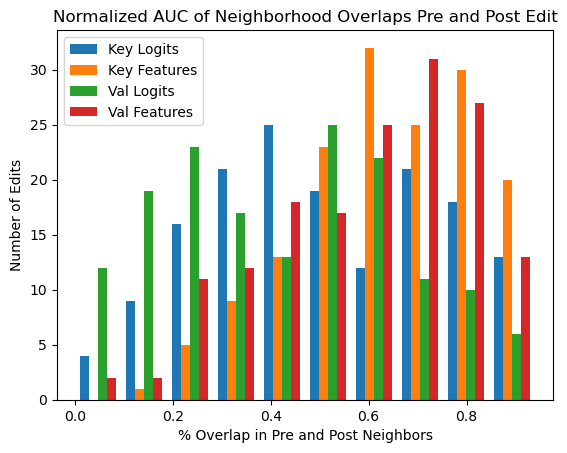

<Figure size 640x480 with 0 Axes>

In [9]:
### Take neighbor analyses and compute AUC
overlaps_path = os.path.join(parent_save_dir, 'neighbor_analysis', 'absolute_pre_post_overlaps.pth')
upper_limit_auc = auc(
    x=[0, K], 
    y=[0, K])
# print(upper_limit)

xs = intervals
pre_post_overlaps = torch.load(overlaps_path)
# print(pre_post_overlaps.values())

# Initialize lists to store AUC
ids = []
key_features_auc = []
key_logits_auc = []
val_features_auc = []
val_logits_auc = []
aucs = {
    'key_logits': key_logits_auc,
    'key_features': key_features_auc,
    'val_logits': val_logits_auc,
    'val_features': val_features_auc
}

for exp_id, overlaps in pre_post_overlaps.items():
    ids .append(exp_id)
    
    # Obtain arrays of overlap
    key_features_overlap = overlaps['key_features']
    key_logits_overlap = overlaps['key_logits']
    
    val_features_overlap = overlaps['val_features']
    val_logits_overlap = overlaps['val_logits']
    
    # Calculate the AUC
    key_features_auc.append(auc(
        x=intervals,
        y=key_features_overlap))
    
    key_logits_auc.append(auc(
        x=intervals,
        y=key_logits_overlap))
    
    val_features_auc.append(auc(
        x=intervals,
        y=val_features_overlap))
    
    val_logits_auc.append(auc(
        x=intervals,
        y=val_logits_overlap))
    # print(key_features_auc, key_logits_auc, val_features_auc, val_logits_auc)

# Convert lists to np.arrays and normalize
for auc_id, cur_auc in aucs.items():
    cur_auc = np.array(cur_auc) / upper_limit_auc
    aucs[auc_id] = cur_auc

histogram_save_path = os.path.join(graph_save_dir, 'normalized_auc_histogram.png')
histogram(
    data=aucs.values(),
    labels=['Key Logits', 'Key Features', 'Val Logits', 'Val Features'],
    title='Normalized AUC of Neighborhood Overlaps Pre and Post Edit',
    xlabel='% Overlap in Pre and Post Neighbors',
    ylabel='Number of Edits',
    save_path=histogram_save_path
)
        

### Sort by Edit Quality and Plot AUC vs Edit Quality


In [11]:
# Load CSV
csv_path = os.path.join(parent_save_dir, 'results_table.csv')
df = load_and_preprocess_csv(
    csv_path=csv_path,
    drop_duplicates=['ID'])

# Check that the row ordering of the CSV is same as lists for AUC
for row_idx, edit_id in enumerate(df['ID']):
    overlap_edit_id = ids[row_idx]
    assert overlap_edit_id in edit_id, "Mismatch in row {}. Found {} from overlaps and found {} from dataframe".format(
        row_idx, overlap_edit_id, edit_id)
    
# Check columns in sort_columns are in dataframe
# for column in sort_columns:
#     assert column in df.columns

# sort_columns = ['Post Accuracy']
# sort_columns = ['Post Target Accuracy']
# sort_columns = ['Post Target Recall']

metrics = ['Accuracy', 'Recall', 'Precision', 'F1']
groups = ['Mean', 'Target', 'Orig Pred']

key = 'Post {} {}'
n_cols = 3


# sort_criteria = sort_columns[0].lower().replace(' ', '_')
# sort_graph_save_dir = os.path.join(graph_save_dir, sort_criteria)
# ensure_dir(sort_graph_save_dir)

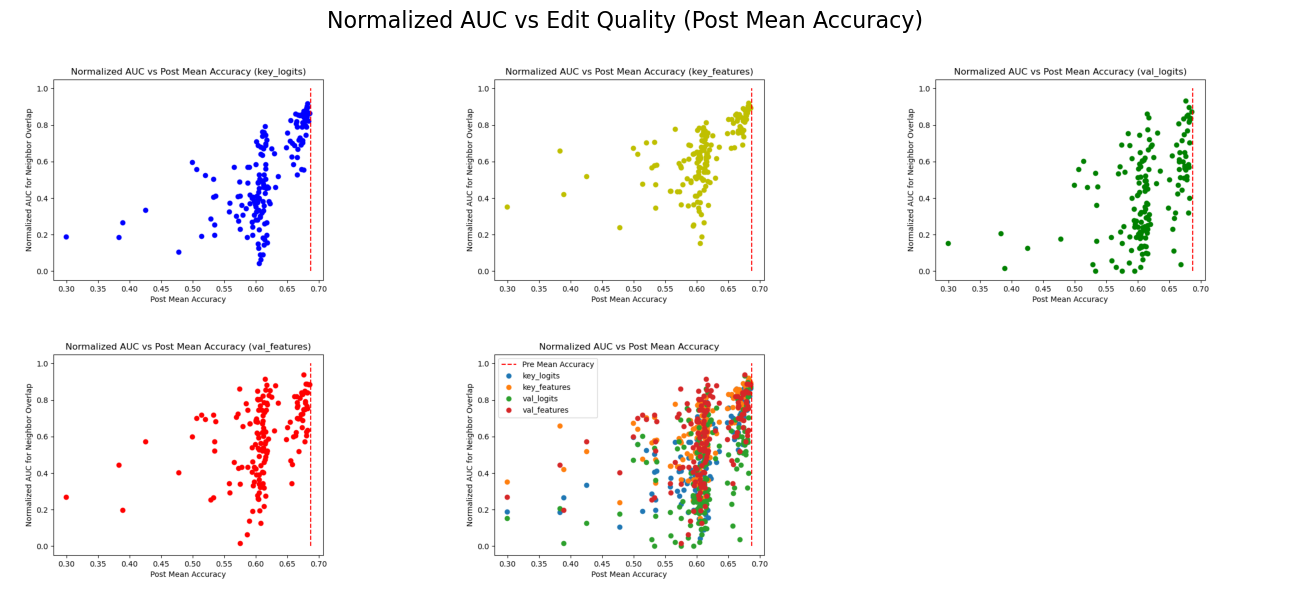

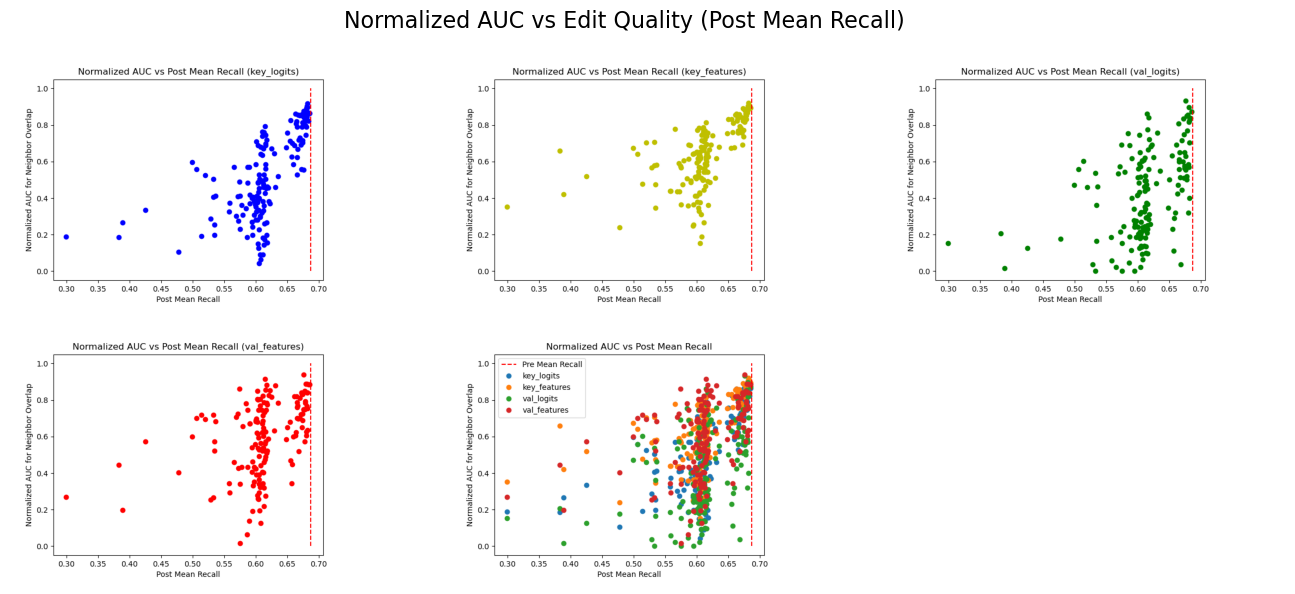

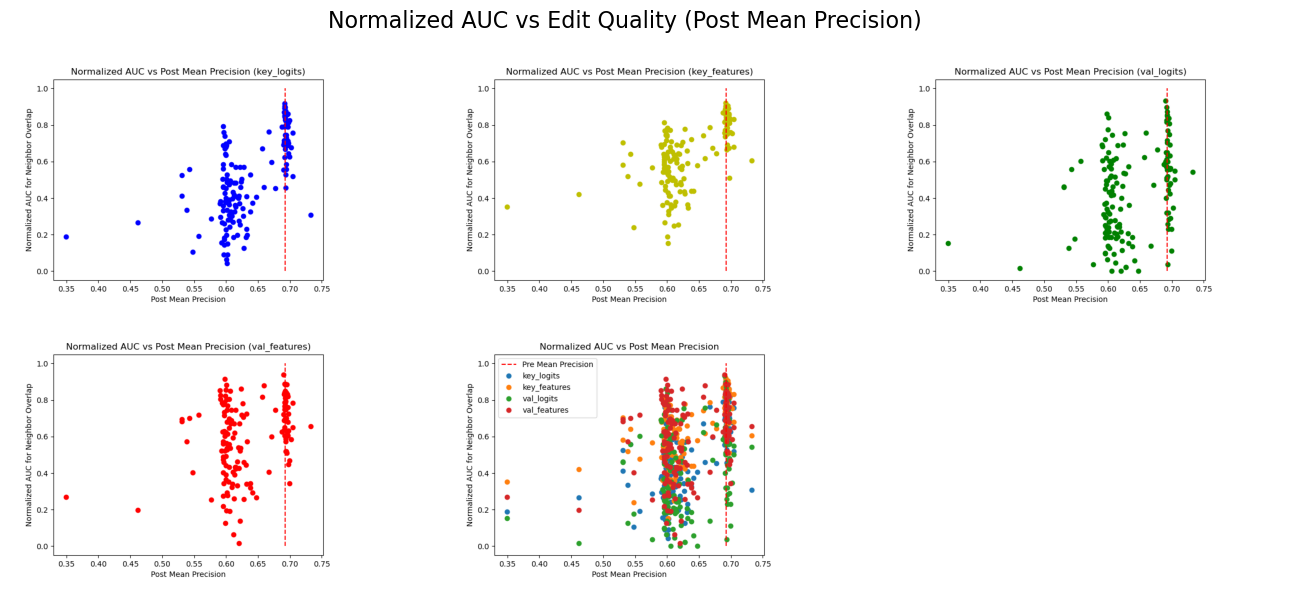

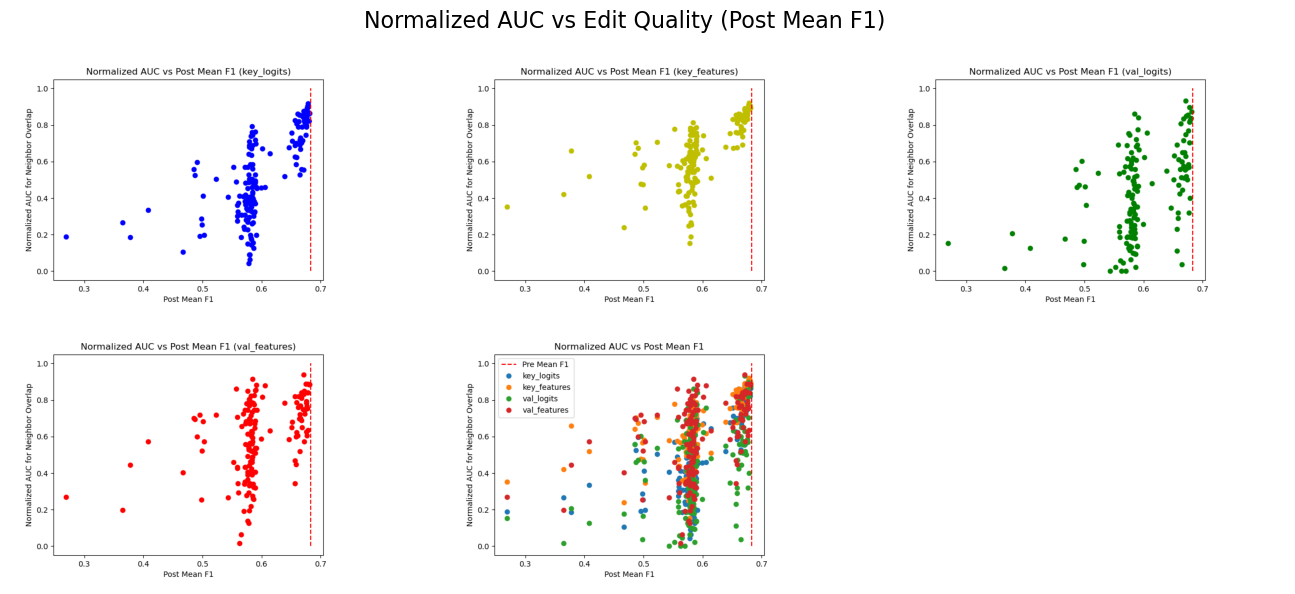

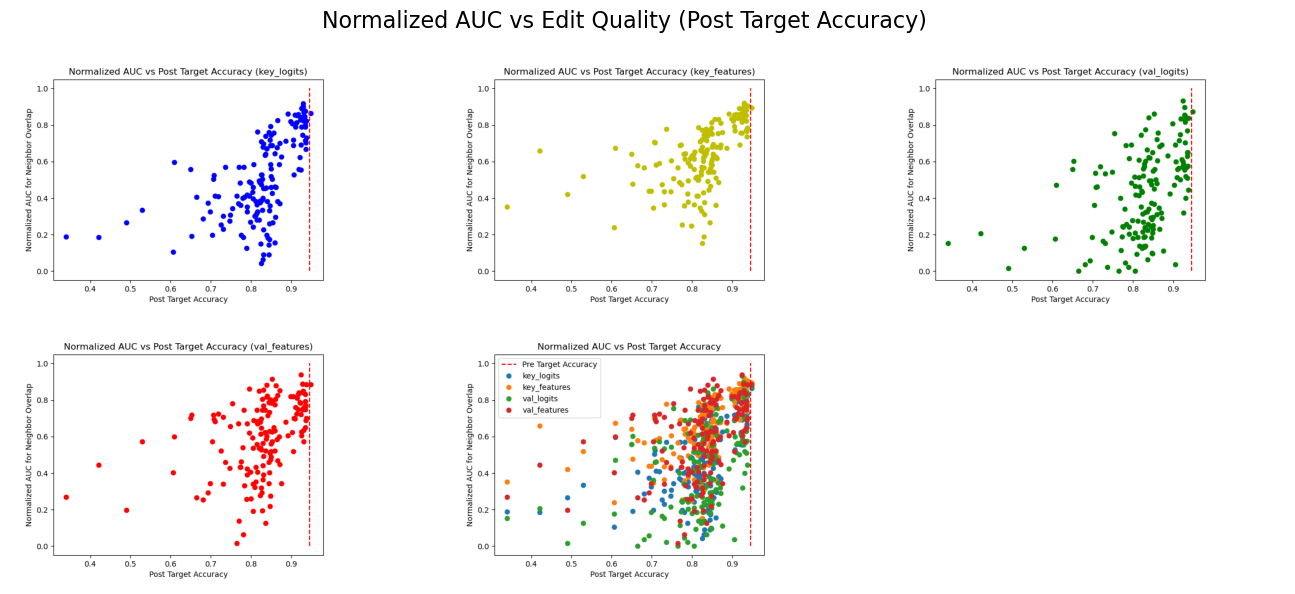

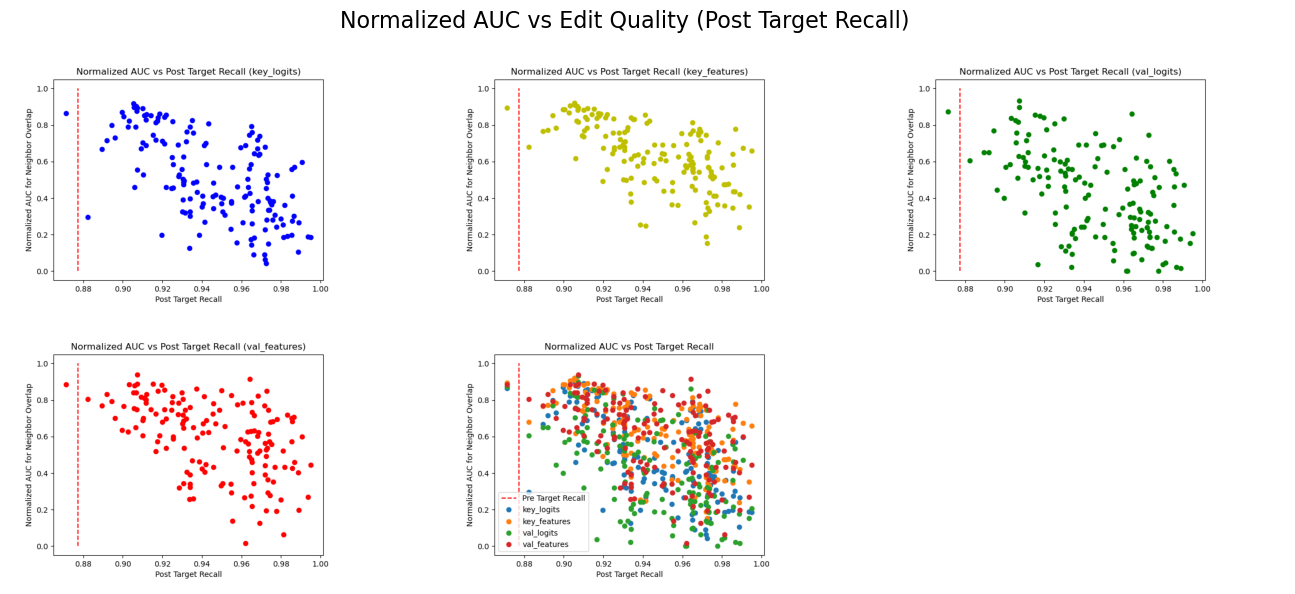

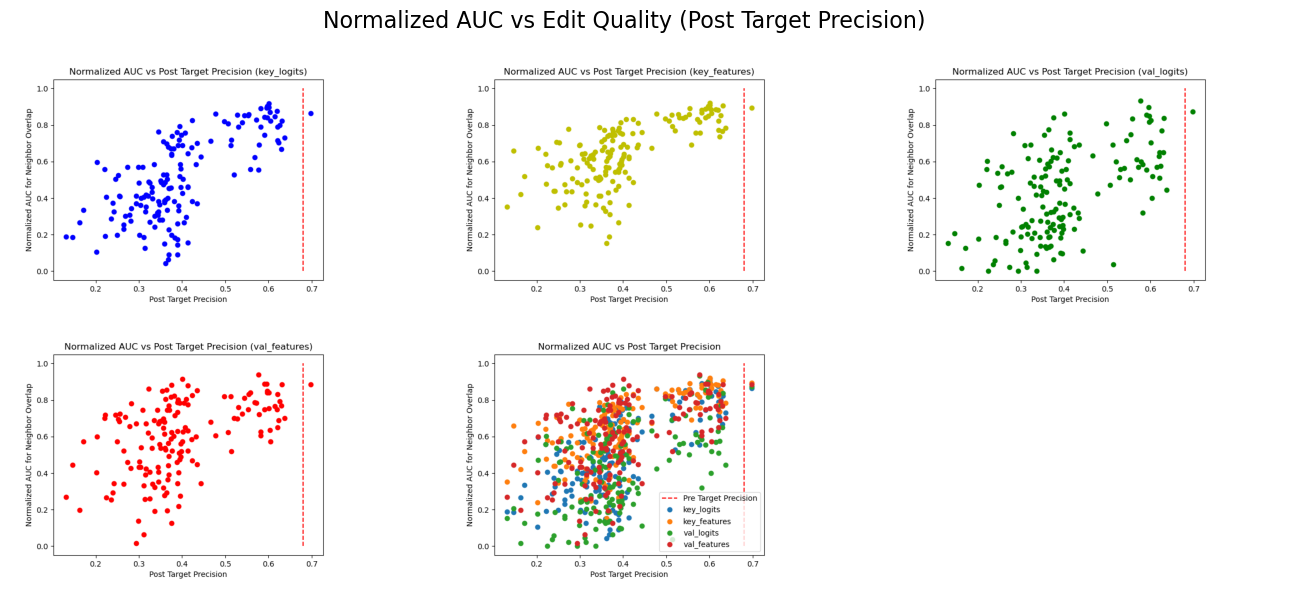

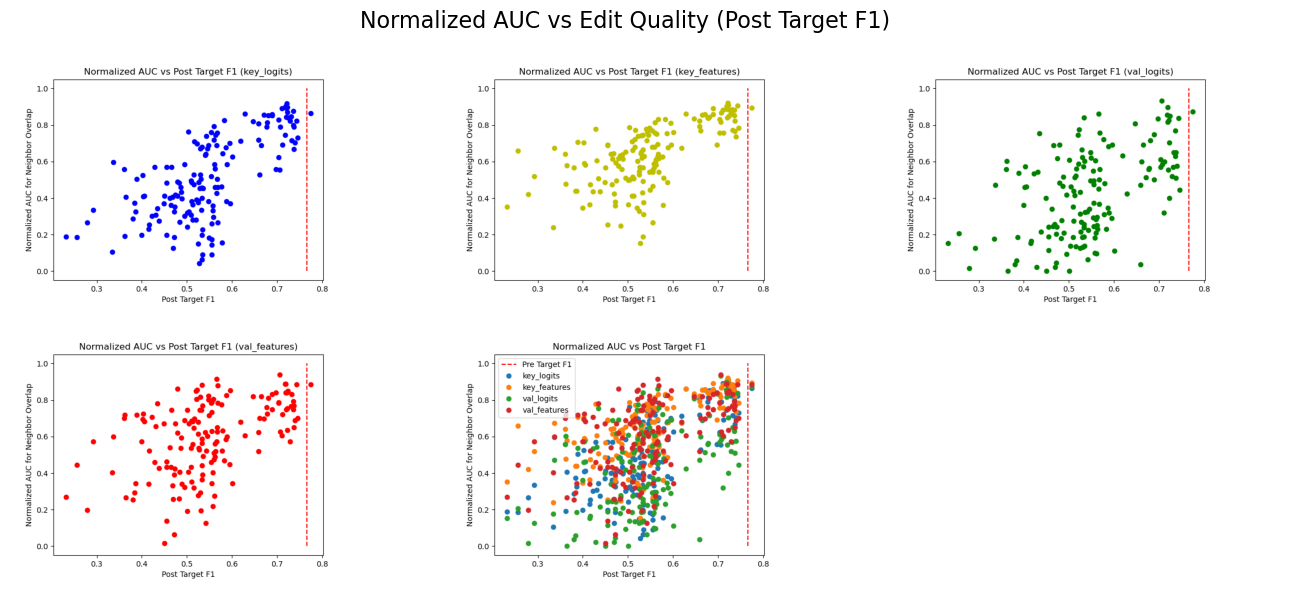

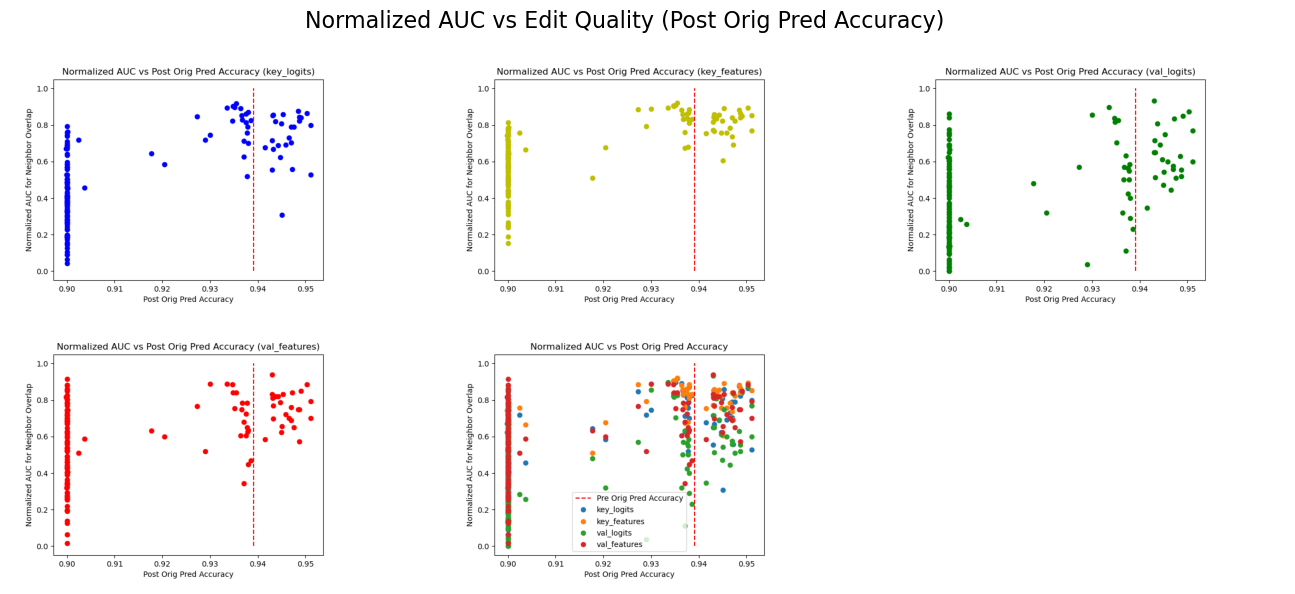

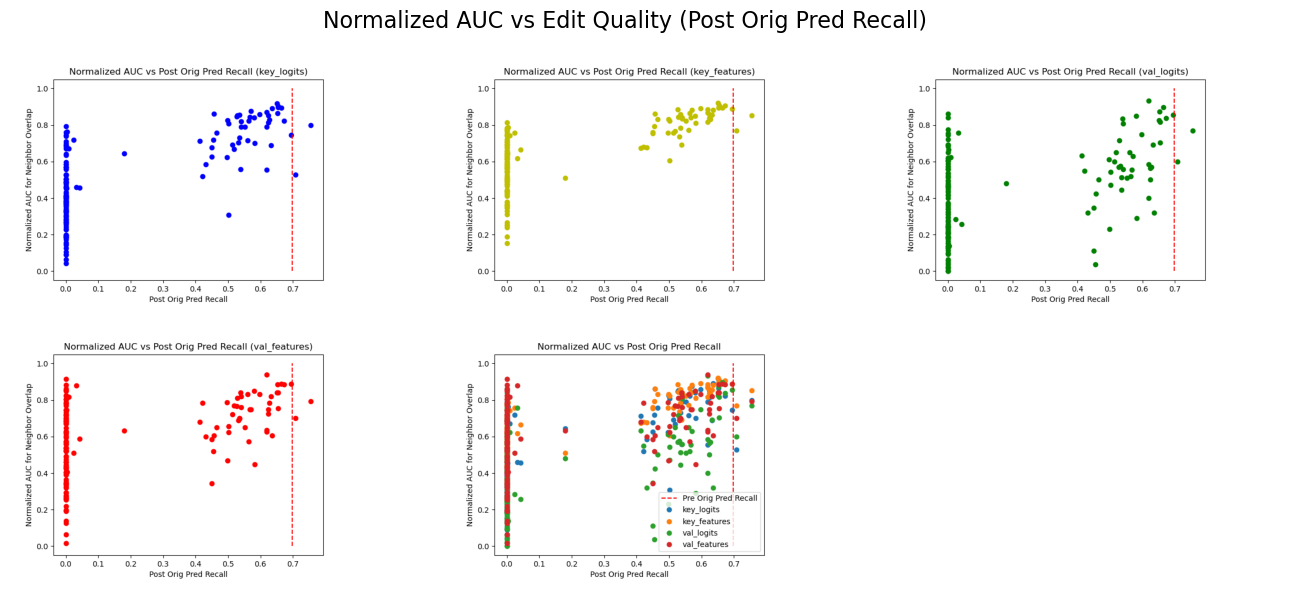

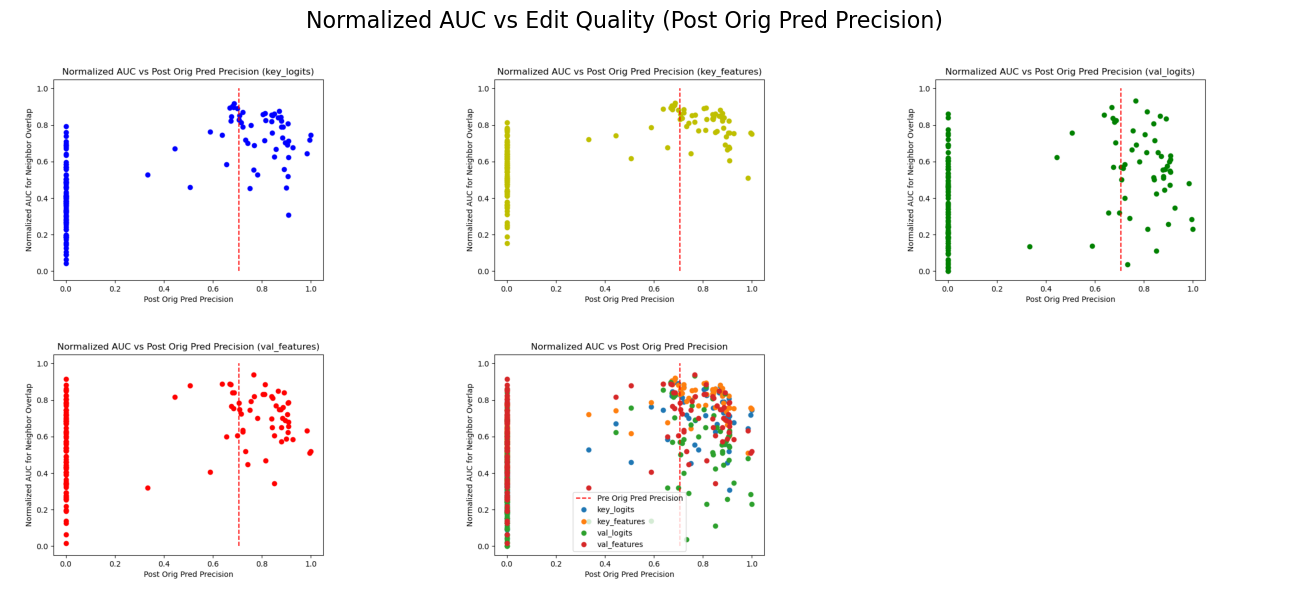

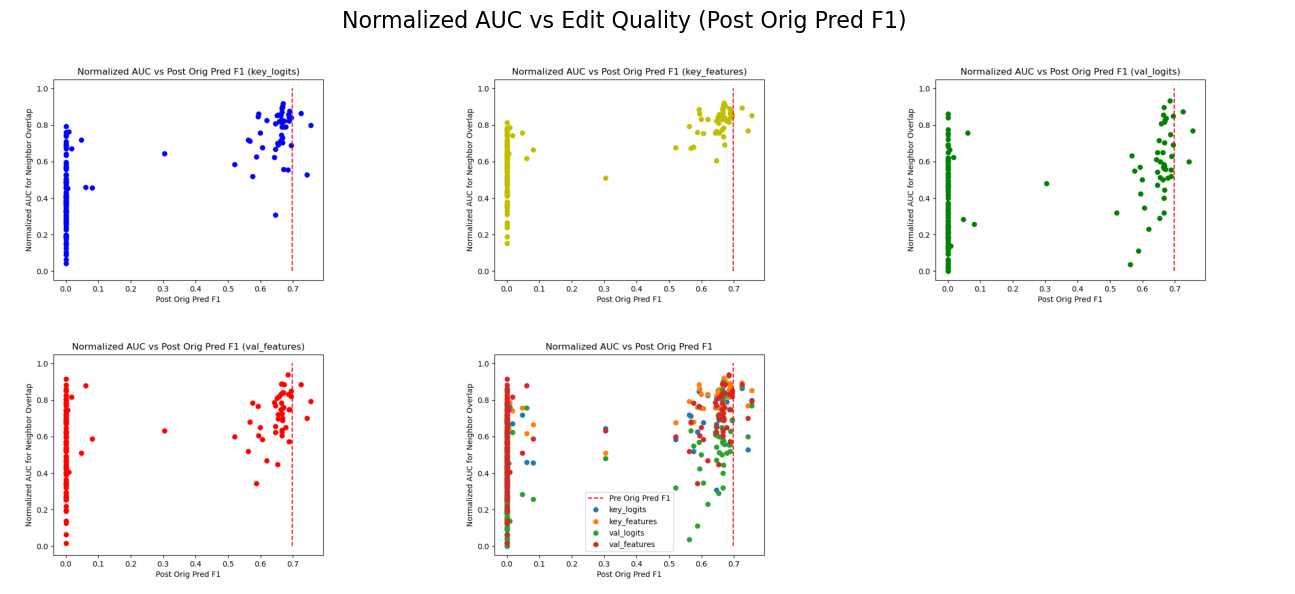

In [19]:
for group in groups:
    for metric in metrics:
        metric_key = key.format(group, metric)
        
        # String formatting and create directory for this metric
        sort_criteria = metric_key.lower().replace(' ', '_')
        
        sort_graph_save_dir = os.path.join(graph_save_dir, sort_criteria)
        ensure_dir(sort_graph_save_dir)
        
        sorted_df, sorted_idxs = get_sorted_idxs(
        df=df,
        columns=[metric_key],
        increasing=False)
        
        # Plot % Overlaps vs Edit Quality for each metric, diff graph per key/val logit/features combination
        edit_quality = df[metric_key]
        xlabel = metric_key
        ylabel = 'Normalized AUC for Neighbor Overlap'
        colors = ['b', 'y', 'g', 'r']
        
        
        pre_edit_metric = df[metric_key.replace("Post", "Pre")].to_numpy()
        pre_edit_metric = np.mean(pre_edit_metric)

        for auc_idx, (auc_id, cur_auc) in enumerate(aucs.items()):
            xlabel_ = xlabel.replace(' ', '_').lower()
            save_plot_path = os.path.join(sort_graph_save_dir, '{}_normalized_auc_vs_edit_quality.png'.format(auc_id))
            plot(
                xs=[edit_quality],
                ys=[cur_auc],
                title='Normalized AUC vs {} ({})'.format(xlabel, auc_id),
                colors=colors[auc_idx],
                xlabel=xlabel,
                ylabel=ylabel,
                highlight=([pre_edit_metric, pre_edit_metric], [0, 1]),
                highlight_label=metric_key.replace("Post", "Pre"),
                line=False,
                show=False,
                save_path=save_plot_path)
        
        # Plot all 4 on the same axes
        xs = [edit_quality for i in range(len(aucs.items()))],

        save_plot_path = os.path.join(sort_graph_save_dir, 'normalized_auc_vs_{}.png'.format(xlabel_))
    
        plot(
            xs=xs[0],
            ys=list(aucs.values()),
            title='Normalized AUC vs {}'.format(xlabel),
            labels=[key for key in aucs.keys()],
            xlabel=xlabel,
            ylabel=ylabel,
            highlight=([pre_edit_metric, pre_edit_metric], [0, 1]),
            highlight_label=metric_key.replace("Post", "Pre"),
            line=False,
            show=False,
            save_path=save_plot_path)
        plt.close('all')
        
        # Put all figures on 1 image
        images = []
        filenames = [
            'key_logits_normalized_auc_vs_edit_quality.png',
            'key_features_normalized_auc_vs_edit_quality.png',
            'val_logits_normalized_auc_vs_edit_quality.png',
            'val_features_normalized_auc_vs_edit_quality.png',
            'normalized_auc_vs_{}.png']
        for graph_filename in filenames:
            graph_filename = graph_filename.format(sort_criteria)
            image = load_image(os.path.join(sort_graph_save_dir, graph_filename))
            images.append(image)

        images = make_grid(images, items_per_row=n_cols)
        save_fig_path = os.path.join(sort_graph_save_dir, 'auc_neighbors_summary.png'.format(sort_criteria))
        
        show_image_rows(
            images=images,
            image_size=(4.5, 3),
            subplot_padding=1,
            figure_title='Normalized AUC vs Edit Quality ({})'.format(metric_key),
            font_size=16,
            save_path=save_fig_path
        )
        plt.close('all')
        
        # break

#### Sanity checks

In [28]:
# # Sort dataframe by sort_columns
# sorted_df, sorted_idxs = get_sorted_idxs(
#     df=df,
#     columns=sort_columns,
#     increasing=False)

### Plot edit quality (post target accuracy) vs overlaps

In [29]:
# edit_quality = df[sort_columns]
# xlabel = str(*sort_columns)
# ylabel = 'Normalized AUC for Neighbor Overlap'
# colors = ['b', 'y', 'g', 'r']

# for auc_idx, (auc_id, cur_auc) in enumerate(aucs.items()):
#     xlabel_ = xlabel.replace(' ', '_').lower()
#     save_plot_path = os.path.join(sort_graph_save_dir, '{}_normalized_auc_vs_{}.png'.format(auc_id, xlabel_))
#     plot(
#         xs=[edit_quality],
#         ys=[cur_auc],
#         title='Normalized AUC vs {} ({})'.format(xlabel, auc_id),
#         colors=colors[auc_idx],
#         xlabel=xlabel,
#         ylabel=ylabel,
#         line=False,
#         show=False,
#         save_path=save_plot_path)

plt.close('all')

     Post Target Recall
0              0.941000
1              0.995143
2              0.951571
3              0.966286
4              0.938714
..                  ...
153            0.972429
154            0.965143
155            0.986857
156            0.924571
157            0.925429

[158 rows x 1 columns]


In [30]:
# Plot all 4 on the same axes
xs = [edit_quality for i in range(len(aucs.items()))],

save_plot_path = os.path.join(sort_graph_save_dir, 'normalized_auc_vs_{}.png'.format(xlabel_))

plot(
    xs=xs[0],
    ys=list(aucs.values()),
    title='Normalized AUC vs {}'.format(xlabel),
    labels=[key for key in aucs.keys()],
    xlabel=xlabel,
    ylabel=ylabel,
    line=False,
    show=False,
    save_path=save_plot_path)
plt.close('all')

### Combine all plots in `graphs/neighbor_analysis` into one image

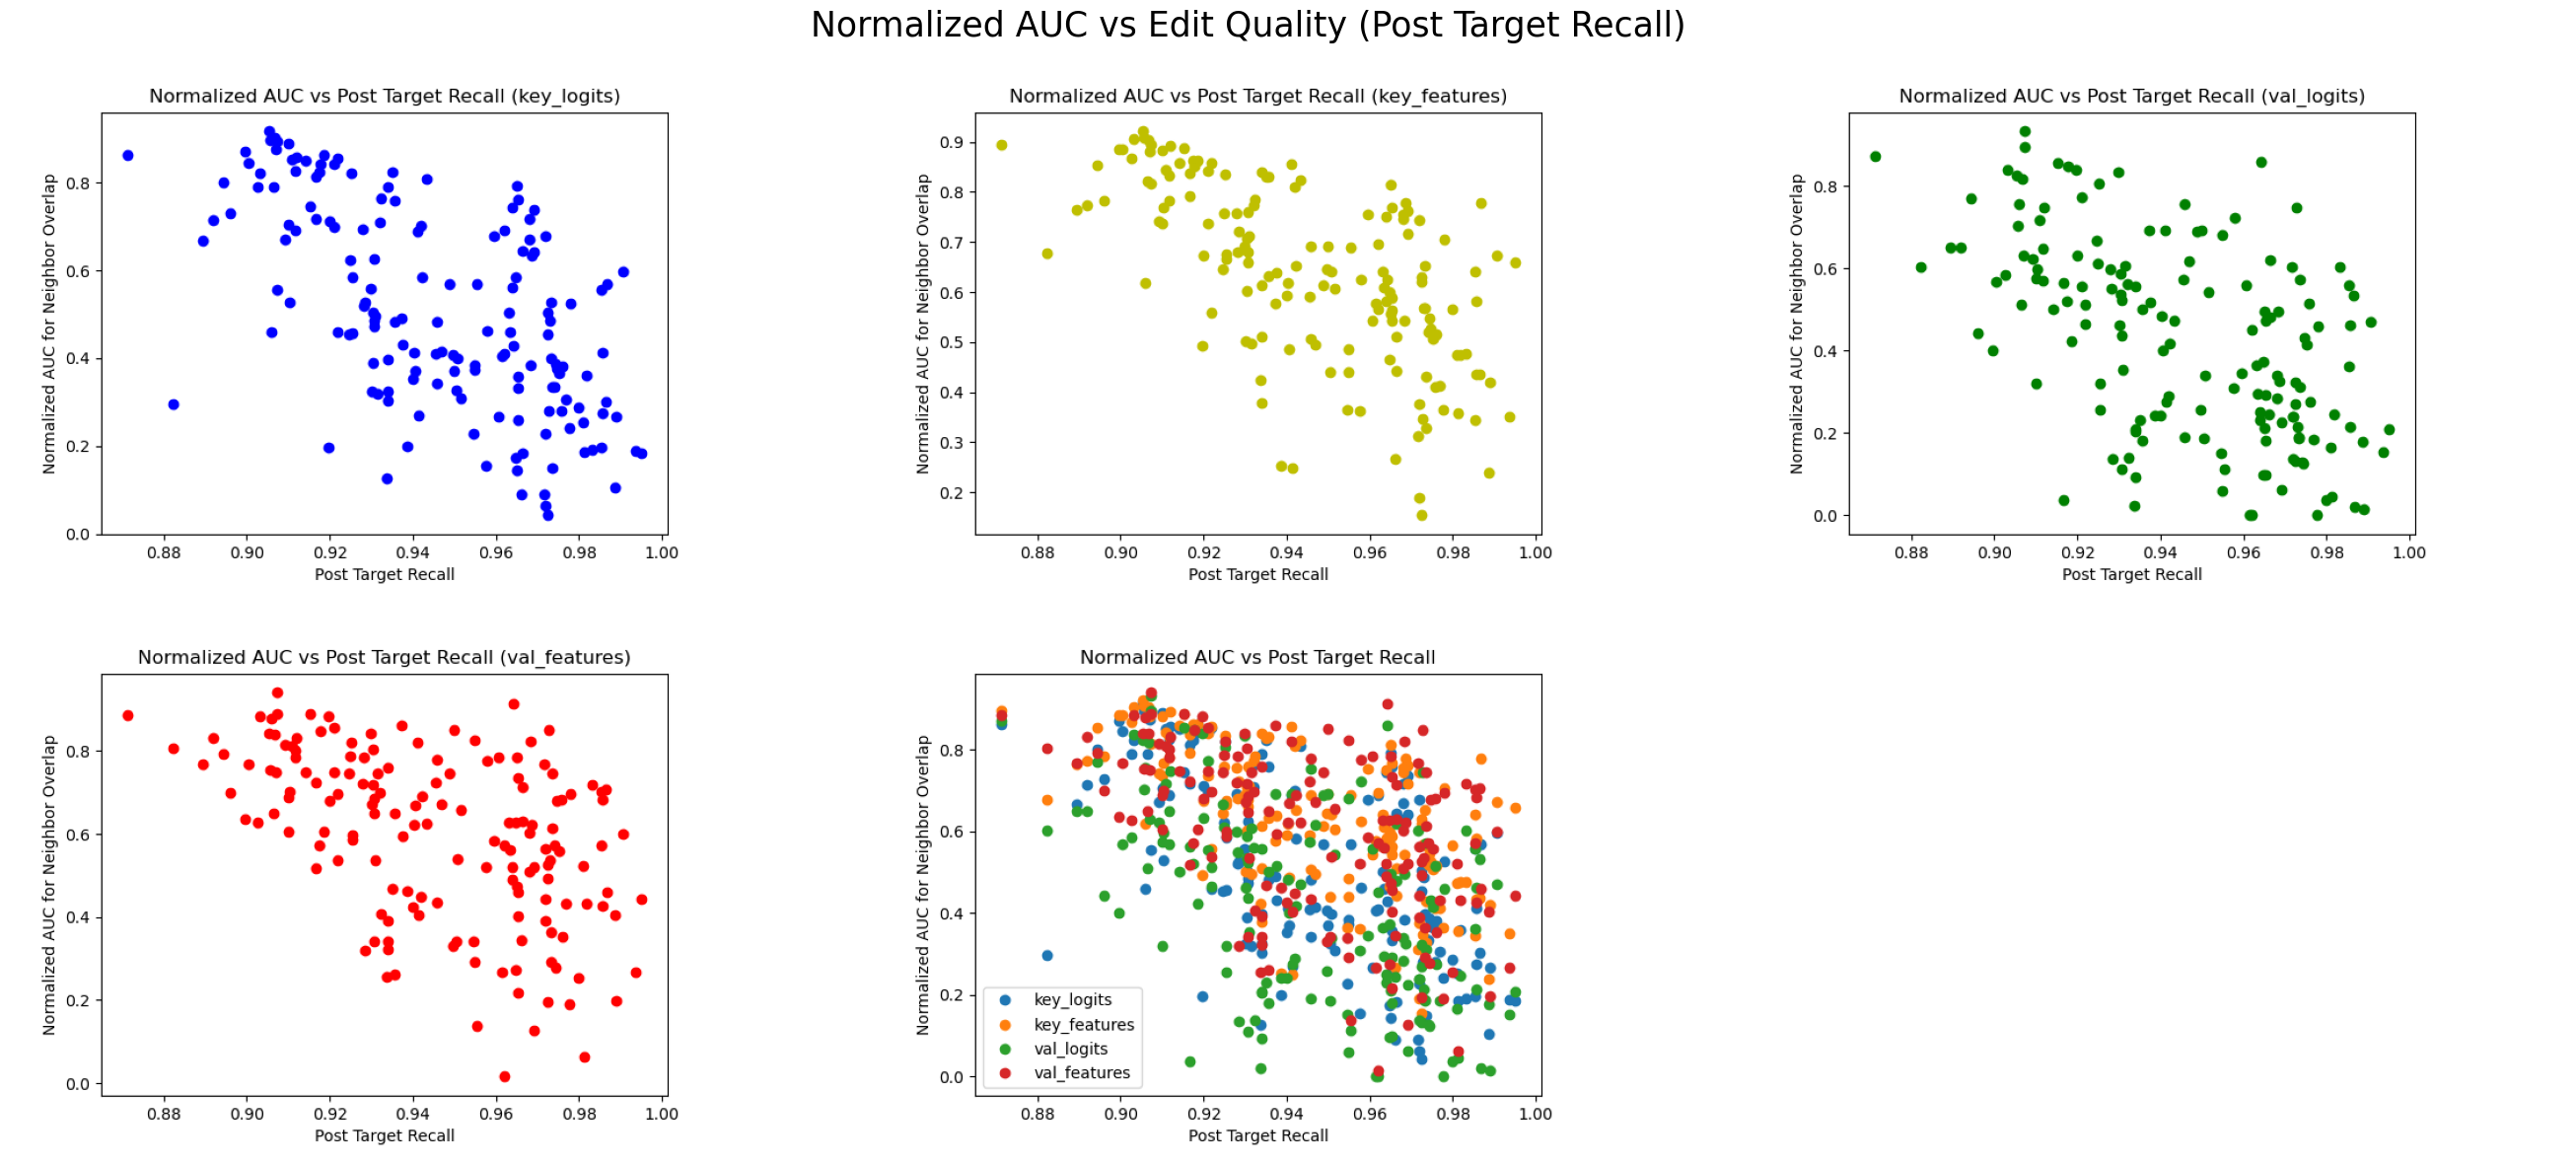

In [31]:
images = []
n_cols = 3
filenames = [
    'key_logits_normalized_auc_vs_{}.png',
    'key_features_normalized_auc_vs_{}.png',
    'val_logits_normalized_auc_vs_{}.png',
    'val_features_normalized_auc_vs_{}.png',
    'normalized_auc_vs_{}.png']
for graph_filename in filenames:
    graph_filename = graph_filename.format(sort_criteria)
    image = load_image(os.path.join(sort_graph_save_dir, graph_filename))
    images.append(image)

images = make_grid(images, items_per_row=n_cols)
# image = load_image('saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/graphs/neighbor_analysis/key_logits_normalized_auc_vs_post_target_accuracy.png')
# image2 = load_image('saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0127_103716/graphs/neighbor_analysis/key_logits_normalized_auc_vs_post_target_accuracy.png')

save_fig_path = os.path.join(sort_graph_save_dir, 'auc_neighbors_summary_{}.png'.format(sort_criteria))
show_image_rows(
    images=images,
    image_size=(9, 6),
    subplot_padding=1,
    figure_title='Normalized AUC vs Edit Quality ({})'.format(sort_columns[0]),
    font_size=25,
    save_path=save_fig_path
)
plt.close('all')